In [5]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#16a085', '#e8f6f3', '#d0ece7', '#a2d9ce', '#73c6b6', '#45b39d', 
                        '#16a085', '#138d75', '#117a65', '#0e6655', '#0b5345']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [7]:
%%capture
!pip install lightautoml

In [8]:
%%capture
!pip install -U pandas

In [9]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch
import math

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [10]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 1000 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [11]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [12]:
INPUT_DIR = '../input/sf-dst-predict-car-price/'

In [13]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [14]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [15]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### 0. Функции, которые в дальнейшем будем использовать

#### Вывод данных на график

In [16]:
def get_graph(df: pd.DataFrame, column_name: str, bins=500, width=20, height=10):
    """
    Функция для построения гистрограммы и boxplot
    для оценки распределения и поиска выбросов

    :param df: Исходный датафрейм
    :param column_name: Имя признака для анализа
    :param bins: Количество групп по умолчанию 500
    :width: Высота графика
    :height: Ширина графика
    :return: Выводит график
    """

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(width, height))
    axes[0].ticklabel_format(style='plain', axis='x')
    histplot = sns.histplot(data=df, x=column_name, bins=bins, ax=axes[0])

    histplot.set_title(f'{column_name} Histogram')
    axes[1].ticklabel_format(style='plain', axis='x')
    boxplot = sns.boxplot(data=df, x=column_name, ax=axes[1])
    boxplot.set_title(f'{column_name} Boxplot')

    plt.tight_layout()
    plt.show()

#### Удаление выбросов методом Тьюки

In [17]:
def outliers_iqr(df: pd.DataFrame, feature: str, log_scale=False, left=1.5, right=1.5):
    """
    Функция для определения выбросов по методу Тьюки.

    :param df: Исходный датафрейм
    :param feature: Имя признака для анализа
    :param log_scale: Нужно ли логарифмировать рассмативаемый признак, по умолчанию False
    :param left: Множитель для определения левой границы выброса, по умолчанию 1.5
    :param right: Множитель для определения правой границы выброса, по умолчанию 1.5
    :return: Функция возвращает информацию по кол-ву выбросов, датафрейм с выбросами и отчищенный от выбросов датафрейм
    """

    x = df[feature]

    if log_scale:
        x = np.log(x)

    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)

    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]
    outliers_info = f'Количество выбросов: {outliers.shape[0]} (в процентах: {outliers.shape[0] / df.shape[0] * 100:.2f}%).'

    return outliers_info, outliers, cleaned

#### Делаем словари из числовых и категориальных переменных

In [18]:
def get_param_list(df):
    """
    Функция для получения инфомации по категориальным и числовым признакам

    :param df: Датафрейм для анализа
    :return: Возвращает два списка cat_list - категориальные признаки, val_list - числовые признаки
    """
    
    cat_list = []
    val_list = []
    
    cols_names = list(df.columns)
    
    cat_list = list(train_data.select_dtypes(include=['object']).columns)
    
    for col in cols_names:
        if col not in cat_list:
            val_list.append(col)

            
    return cat_list, val_list     
    

### Маркируем выбросы

In [76]:
def mark_by_index(df, ind_list):
    ind = df[0]
    
    if ind in ind_list:
        return True
    
    return False

## 1. Замена пропущенных значений

### 1.1 Посмотрим в каких столбцах у нас значения пропущенны.

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [21]:
coll_null_percent = train_data.isnull().mean() * 100
coll_with_null = coll_null_percent[coll_null_percent > 0].sort_values(ascending=False)
coll_with_null

car_vin                   67.177143
vehicle_interior_color    19.194286
doors_cnt                  2.128571
vehicle_color              1.145714
vehicle_model              0.020000
vehicle_manufacturer       0.002857
vehicle_category           0.002857
vehicle_gearbox_type       0.002857
wheels                     0.002857
dtype: float64

In [22]:
coll_null_percent = test_data.isnull().mean() * 100
coll_with_null = coll_null_percent[coll_null_percent > 0].sort_values(ascending=False)
coll_with_null

car_vin                   66.663551
vehicle_interior_color    19.426007
doors_cnt                  2.084697
vehicle_color              1.252688
vehicle_model              0.018697
vehicle_manufacturer       0.009348
vehicle_category           0.009348
vehicle_gearbox_type       0.009348
wheels                     0.009348
dtype: float64

#### Так как больше 40% пропусков ни где нет (car_vin далее заполним просто есть или нет ВИН машины), то будем использовать все столбцы
#### Далее числовые пропуска заполним медианной, категорильные заполним модой. Как вариант еще заполнять в разрезе марки машины, но оставим это на будующее

In [23]:
cat_list, val_list = get_param_list(train_data)
cat_list.remove('car_vin')

### Заполним модой значения марок машины в зависимости от завода

In [24]:
rep_val_train = train_data['vehicle_manufacturer'].mode()[0]
rep_val_test = test_data['vehicle_manufacturer'].mode()[0]

train_data['vehicle_manufacturer'].fillna(rep_val_train, inplace=True)
test_data['vehicle_manufacturer'].fillna(rep_val_test, inplace=True)

In [25]:
train_data.loc[train_data.vehicle_manufacturer == 'JAC', 'vehicle_model'] = 'JAC'

manufacture_names = []
for idx in train_data['vehicle_manufacturer'].value_counts().index:
    manufacture_names.append(idx)
    
model_mode_dict = {}
for name in manufacture_names:
    mode_val = train_data[train_data['vehicle_manufacturer']==name]['vehicle_model'].mode()[0]
    model_mode_dict[name] = mode_val
    
for key, val in model_mode_dict.items():
    new_df = train_data[train_data['vehicle_manufacturer']==key]['vehicle_model']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        train_data.loc[idx, 'vehicle_model'] = new_df.loc[idx]
    

In [26]:
manufacture_names_test = []
for idx in test_data['vehicle_manufacturer'].value_counts().index:
    manufacture_names_test.append(idx)
    
model_mode_dict_test = {}
for name in manufacture_names_test:
    mode_val = test_data[test_data['vehicle_manufacturer']==name]['vehicle_model'].mode()[0]
    model_mode_dict_test[name] = mode_val
    
for key, val in model_mode_dict_test.items():
    new_df = test_data[test_data['vehicle_manufacturer']==key]['vehicle_model']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        test_data.loc[idx, 'vehicle_model'] = new_df.loc[idx]

In [27]:
train_data.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [28]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10696 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10474 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  8619 non-null   object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### Заполним модой значения цвета интерьера машины в зависимости от марки машины

In [29]:
# Марки машин у которых не было вообще ни какой информации о цвете. Взял черный, так как самый частый цвет. По хорошему надо было смотреть у диллеров, 
# какой цвет лучше всего продается, но это пока что лень...

vehicle_names_train = [] 
for idx in train_data['vehicle_model'].value_counts().index:
    vehicle_names_train.append(idx)
    
color_mode_dict_train = {}
for name in vehicle_names_train:
    mode_len = len(train_data[train_data['vehicle_model']==name]['vehicle_interior_color'].mode())
    
    if mode_len == 0:
        model_val = 'Black'
    else:
        mode_val = train_data[train_data['vehicle_model']==name]['vehicle_interior_color'].mode()[0]

    color_mode_dict_train[name] = mode_val
    
for key, val in color_mode_dict_train.items():
    new_df = train_data[train_data['vehicle_model']==key]['vehicle_interior_color']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        train_data.loc[idx, 'vehicle_interior_color'] = new_df.loc[idx]

In [30]:
vehicle_names_test = [] 
for idx in test_data['vehicle_model'].value_counts().index:
    vehicle_names_test.append(idx)
    
color_mode_dict_test = {}
for name in vehicle_names_test:
    mode_len = len(test_data[test_data['vehicle_model']==name]['vehicle_interior_color'].mode())
    
    if mode_len == 0:
        model_val = 'Black'
    else:
        mode_val = test_data[test_data['vehicle_model']==name]['vehicle_interior_color'].mode()[0]

    color_mode_dict_test[name] = mode_val
    
for key, val in color_mode_dict_test.items():
    new_df = test_data[test_data['vehicle_model']==key]['vehicle_interior_color']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        test_data.loc[idx, 'vehicle_interior_color'] = new_df.loc[idx]

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [103]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10696 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10474 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  10697 non-null  object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### Заполним модой значения количества дверей машины в зависимости от марки машины

In [32]:
# Марки машин у которых не было вообще ни какой информации о количестве дверей. Взял 4/5. По хорошему надо было смотреть у диллеров, 
# какое количество дверей у какой марки, но это пока что лень...

vehicle_names_train = [] 
for idx in train_data['vehicle_model'].value_counts().index:
    vehicle_names_train.append(idx)
    
doors_mode_dict_train = {}
for name in vehicle_names_train:
    mode_len = len(train_data[train_data['vehicle_model']==name]['doors_cnt'].mode())
    
    if mode_len == 0:
        model_val = '4/5'
    else:
        mode_val = train_data[train_data['vehicle_model']==name]['doors_cnt'].mode()[0]

    doors_mode_dict_train[name] = mode_val
    
for key, val in doors_mode_dict_train.items():
    new_df = train_data[train_data['vehicle_model']==key]['doors_cnt']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        train_data.loc[idx, 'doors_cnt'] = new_df.loc[idx]

In [33]:
vehicle_names_test = [] 
for idx in test_data['vehicle_model'].value_counts().index:
    vehicle_names_test.append(idx)
    
doors_mode_dict_test = {}
for name in vehicle_names_test:
    mode_len = len(test_data[test_data['vehicle_model']==name]['doors_cnt'].mode())
    
    if mode_len == 0:
        model_val = '4/5'
    else:
        mode_val = test_data[test_data['vehicle_model']==name]['doors_cnt'].mode()[0]

    doors_mode_dict_test[name] = mode_val
    
for key, val in doors_mode_dict_test.items():
    new_df = test_data[test_data['vehicle_model']==key]['doors_cnt']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        test_data.loc[idx, 'doors_cnt'] = new_df.loc[idx]

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               35000 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [35]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10696 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10697 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  10697 non-null  object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### Заполним модой значения категории машины в зависимости от марки машины

In [36]:
vehicle_names_train = [] 
for idx in train_data['vehicle_model'].value_counts().index:
    vehicle_names_train.append(idx)
    
category_mode_dict_train = {}
for name in vehicle_names_train:
    mode_len = len(train_data[train_data['vehicle_model']==name]['vehicle_category'].mode())
    
    if mode_len == 0:
        model_val = 'Sedan'
    else:
        mode_val = train_data[train_data['vehicle_model']==name]['vehicle_category'].mode()[0]

    category_mode_dict_train[name] = mode_val
    
for key, val in category_mode_dict_train.items():
    new_df = train_data[train_data['vehicle_model']==key]['vehicle_category']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        train_data.loc[idx, 'vehicle_category'] = new_df.loc[idx]

In [37]:
vehicle_names_test = [] 
for idx in test_data['vehicle_model'].value_counts().index:
    vehicle_names_test.append(idx)
    
category_mode_dict_test = {}
for name in vehicle_names_test:
    mode_len = len(test_data[test_data['vehicle_model']==name]['vehicle_category'].mode())
    
    if mode_len == 0:
        model_val = 'Sedan'
    else:
        mode_val = test_data[test_data['vehicle_model']==name]['vehicle_category'].mode()[0]

    category_mode_dict_test[name] = mode_val
    
for key, val in category_mode_dict_test.items():
    new_df = test_data[test_data['vehicle_model']==key]['vehicle_category']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        test_data.loc[idx, 'vehicle_category'] = new_df.loc[idx]

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        35000 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               35000 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10697 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10697 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  10697 non-null  object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### Заполним модой значения типа коробки передач машины в зависимости от марки машины

In [40]:
vehicle_names_train = [] 
for idx in train_data['vehicle_model'].value_counts().index:
    vehicle_names_train.append(idx)
    
gearbox_mode_dict_train = {}
for name in vehicle_names_train:
    mode_len = len(train_data[train_data['vehicle_model']==name]['vehicle_gearbox_type'].mode())
    
    if mode_len == 0:
        model_val = 'Automatic'
    else:
        mode_val = train_data[train_data['vehicle_model']==name]['vehicle_gearbox_type'].mode()[0]

    gearbox_mode_dict_train[name] = mode_val
    
for key, val in gearbox_mode_dict_train.items():
    new_df = train_data[train_data['vehicle_model']==key]['vehicle_gearbox_type']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        train_data.loc[idx, 'vehicle_gearbox_type'] = new_df.loc[idx]

In [41]:
vehicle_names_test = [] 
for idx in test_data['vehicle_model'].value_counts().index:
    vehicle_names_test.append(idx)
    
gearbox_mode_dict_test = {}
for name in vehicle_names_test:
    mode_len = len(test_data[test_data['vehicle_model']==name]['vehicle_gearbox_type'].mode())
    
    if mode_len == 0:
        model_val = 'Automatic'
    else:
        mode_val = test_data[test_data['vehicle_model']==name]['vehicle_gearbox_type'].mode()[0]

    gearbox_mode_dict_test[name] = mode_val
    
for key, val in gearbox_mode_dict_test.items():
    new_df = test_data[test_data['vehicle_model']==key]['vehicle_gearbox_type']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        test_data.loc[idx, 'vehicle_gearbox_type'] = new_df.loc[idx]

In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        35000 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    35000 non-null  object 
 7   doors_cnt               35000 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [43]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10697 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10697 non-null  object
 7   doors_cnt               10697 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  10697 non-null  object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### Заполним модой значения левый/правый руль машины в зависимости от марки машины

In [44]:
vehicle_names_train = [] 
for idx in train_data['vehicle_model'].value_counts().index:
    vehicle_names_train.append(idx)
    
wheels_mode_dict_train = {}
for name in vehicle_names_train:
    mode_len = len(train_data[train_data['vehicle_model']==name]['wheels'].mode())
    
    if mode_len == 0:
        model_val = 'Left wheel'
    else:
        mode_val = train_data[train_data['vehicle_model']==name]['wheels'].mode()[0]

    wheels_mode_dict_train[name] = mode_val
    
for key, val in wheels_mode_dict_train.items():
    new_df = train_data[train_data['vehicle_model']==key]['wheels']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        train_data.loc[idx, 'wheels'] = new_df.loc[idx]

In [45]:
vehicle_names_test = [] 
for idx in test_data['vehicle_model'].value_counts().index:
    vehicle_names_test.append(idx)
    
wheels_mode_dict_test = {}
for name in vehicle_names_test:
    mode_len = len(test_data[test_data['vehicle_model']==name]['wheels'].mode())
    
    if mode_len == 0:
        model_val = 'Left wheel'
    else:
        mode_val = test_data[test_data['vehicle_model']==name]['wheels'].mode()[0]

    wheels_mode_dict_test[name] = mode_val
    
for key, val in wheels_mode_dict_test.items():
    new_df = test_data[test_data['vehicle_model']==key]['wheels']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        test_data.loc[idx, 'wheels'] = new_df.loc[idx]

In [46]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        35000 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    35000 non-null  object 
 7   doors_cnt               35000 non-null  object 
 8   wheels                  35000 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [47]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10697 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10697 non-null  object
 7   doors_cnt               10697 non-null  object
 8   wheels                  10697 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  10697 non-null  object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### Заполним модой значения цвета машины в зависимости от марки машины

In [48]:
vehicle_names_train = [] 
for idx in train_data['vehicle_model'].value_counts().index:
    vehicle_names_train.append(idx)
    
color_auto_mode_dict_train = {}
for name in vehicle_names_train:
    mode_len = len(train_data[train_data['vehicle_model']==name]['vehicle_color'].mode())
    
    if mode_len == 0:
        model_val = 'Black'
    else:
        mode_val = train_data[train_data['vehicle_model']==name]['vehicle_color'].mode()[0]

    color_auto_mode_dict_train[name] = mode_val
    
for key, val in color_auto_mode_dict_train.items():
    new_df = train_data[train_data['vehicle_model']==key]['vehicle_color']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        train_data.loc[idx, 'vehicle_color'] = new_df.loc[idx]

In [49]:
vehicle_names_test = [] 
for idx in test_data['vehicle_model'].value_counts().index:
    vehicle_names_test.append(idx)
    
color_auto_mode_dict_test = {}
for name in vehicle_names_test:
    mode_len = len(test_data[test_data['vehicle_model']==name]['vehicle_color'].mode())
    
    if mode_len == 0:
        model_val = 'Black'
    else:
        mode_val = test_data[test_data['vehicle_model']==name]['vehicle_color'].mode()[0]

    color_auto_mode_dict_test[name] = mode_val
    
for key, val in color_auto_mode_dict_test.items():
    new_df = test_data[test_data['vehicle_model']==key]['vehicle_color']
    new_df = new_df.fillna(val)
    
    idx_list = new_df.index
    for idx in idx_list:
        test_data.loc[idx, 'vehicle_color'] = new_df.loc[idx]

In [50]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        35000 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    35000 non-null  object 
 7   doors_cnt               35000 non-null  object 
 8   wheels                  35000 non-null  object 
 9   vehicle_color           35000 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [51]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10697 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10697 non-null  object
 7   doors_cnt               10697 non-null  object
 8   wheels                  10697 non-null  object
 9   vehicle_color           10697 non-null  object
 10  vehicle_interior_color  10697 non-null  object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### car_vin превратим в флаг если нет, то 0, если есть 1

In [52]:
train_data['car_vin'].fillna(0, inplace=True)
train_data.loc[(train_data['car_vin'] != 0), 'car_vin'] = 1

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    35000 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        35000 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    35000 non-null  object 
 7   doors_cnt               35000 non-null  object 
 8   wheels                  35000 non-null  object 
 9   vehicle_color           35000 non-null  object 
 10  vehicle_interior_color  35000 non-null  object 
 11  car_vin                 35000 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [53]:
test_data['car_vin'].fillna(0, inplace=True)
test_data.loc[(test_data['car_vin'] != 0), 'car_vin'] = 1

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10697 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10697 non-null  object
 7   doors_cnt               10697 non-null  object
 8   wheels                  10697 non-null  object
 9   vehicle_color           10697 non-null  object
 10  vehicle_interior_color  10697 non-null  object
 11  car_vin                 10697 non-null  object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


## 2. Посмотрим теперь признаки

### deal_type

In [60]:
rent_cars_index_train = list(train_data[train_data['deal_type'] == 'For Rent'].index)
rent_cars_index_test = list(test_data[test_data['deal_type'] == 'For Rent'].index)

### vehicle_year

In [61]:
ind = train_data[train_data['vehicle_year'] == 0].index
train_data.drop(ind, inplace=True)

In [62]:
vehicle_year_index_test = test_data[test_data['vehicle_year'] == 0].index[0]

In [63]:
def get_age_car(data):
    data['vehicle_age'] = 2021 - data['vehicle_year'] # Соревнование было запущено в 2021 году, его берем за базу
    data = data.drop(columns=['vehicle_year'], axis=1)
    return data

In [65]:
train_data = get_age_car(train_data)
test_data = get_age_car(test_data)

In [66]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34999 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  34999 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34999 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         34999 non-null  int64  
 5   vehicle_gearbox_type    34999 non-null  object 
 6   doors_cnt               34999 non-null  object 
 7   wheels                  34999 non-null  object 
 8   vehicle_color           34999 non-null  object 
 9   vehicle_interior_color  34999 non-null  object 
 10  car_vin                 34999 non-null  object 
 11  car_leather_interior    34999 non-null  int64  
 12  deal_type               34999 non-null  object 
 13  final_price             34999 non-null  float64
 14  vehicle_age             34999 non-null

In [67]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10697 non-null  object
 2   vehicle_model           10697 non-null  object
 3   vehicle_category        10697 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_gearbox_type    10697 non-null  object
 6   doors_cnt               10697 non-null  object
 7   wheels                  10697 non-null  object
 8   vehicle_color           10697 non-null  object
 9   vehicle_interior_color  10697 non-null  object
 10  car_vin                 10697 non-null  object
 11  car_leather_interior    10697 non-null  int64 
 12  deal_type               10697 non-null  object
 13  vehicle_age             10697 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### current_mileage

In [69]:
train_data['current_mileage'].describe()

count    3.499900e+04
mean     1.969280e+06
std      5.682482e+07
min      0.000000e+00
25%      7.145400e+04
50%      1.290000e+05
75%      1.900000e+05
max      2.147484e+09
Name: current_mileage, dtype: float64

In [70]:
train_data[train_data['current_mileage'] > 1_000_000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age
316,316,SUZUKI,Grand Vitara,Jeep,2147483647,Manual,4/5,Left wheel,Carnelian red,Black,1,1,For Rent,2073.0,22
358,358,MERCEDES-BENZ,E 200,Sedan,2844468,Manual,4/5,Left wheel,Blue,Black,0,0,For Sale,3500.0,20
613,613,SUBARU,Legacy,Universal,1980000,Tiptronic,4/5,Right-hand drive,Black,Black,0,0,For Sale,2200.0,16
660,660,MITSUBISHI,Pajero,Jeep,1111111,Automatic,4/5,Left wheel,Golden,Brown,0,0,For Sale,2000.0,25
824,824,SUZUKI,Swift,Hatchback,23000000,Manual,4/5,Right-hand drive,Silver,Beige,0,0,For Sale,733.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34052,34052,MERCEDES-BENZ,ML 320,Jeep,111111111,Tiptronic,4/5,Left wheel,White,Black,0,1,For Sale,6666666.0,19
34230,34230,OPEL,Astra,Sedan,111111111,Manual,4/5,Left wheel,Silver,White,0,0,For Sale,1700.0,22
34360,34360,FORD,Transit,Microbus,1111111,Manual,2/3,Left wheel,White,Grey,0,0,For Sale,4100.0,21
34791,34791,MERCEDES-BENZ,200,Sedan,3000000,Manual,4/5,Left wheel,Green,Black,0,0,For Sale,2000.0,23


In [71]:
test_data[test_data['current_mileage'] > 1_000_000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,vehicle_age
153,35153,RENAULT,Kangoo,Universal,584697469,Manual,4/5,Left wheel,Silver,Grey,0,0,For Sale,18
162,35162,MERCEDES-BENZ,S 500,Sedan,2600000,Tiptronic,4/5,Left wheel,Silver,Black,0,1,For Sale,19
224,35224,MERCEDES-BENZ,CLS 500,Sedan,2147483647,Tiptronic,4/5,Left wheel,Silver,Black,0,1,For Sale,15
269,35269,VAZ,2121 (Niva),Jeep,10000000,Manual,4/5,Left wheel,White,Black,0,0,For Sale,21
525,35525,BMW,525,Sedan,7777787,Manual,4/5,Left wheel,Silver,Grey,0,1,For Sale,18
737,35737,OPEL,Vectra,Sedan,777777777,Automatic,4/5,Left wheel,Beige,Black,0,0,For Sale,24
823,35823,OPEL,Astra,Goods wagon,2600000,Manual,4/5,Left wheel,Silver,Black,0,0,For Sale,14
1052,36052,VOLKSWAGEN,Golf,Sedan,2147483647,Manual,4/5,Left wheel,Black,Black,0,0,For Sale,22
1072,36072,TOYOTA,Prius,Sedan,2147483647,Automatic,4/5,Left wheel,Blue,Grey,0,0,For Sale,13
1096,36096,VOLKSWAGEN,Jetta,Sedan,111111111,Manual,4/5,Left wheel,Black,Black,0,1,For Sale,21


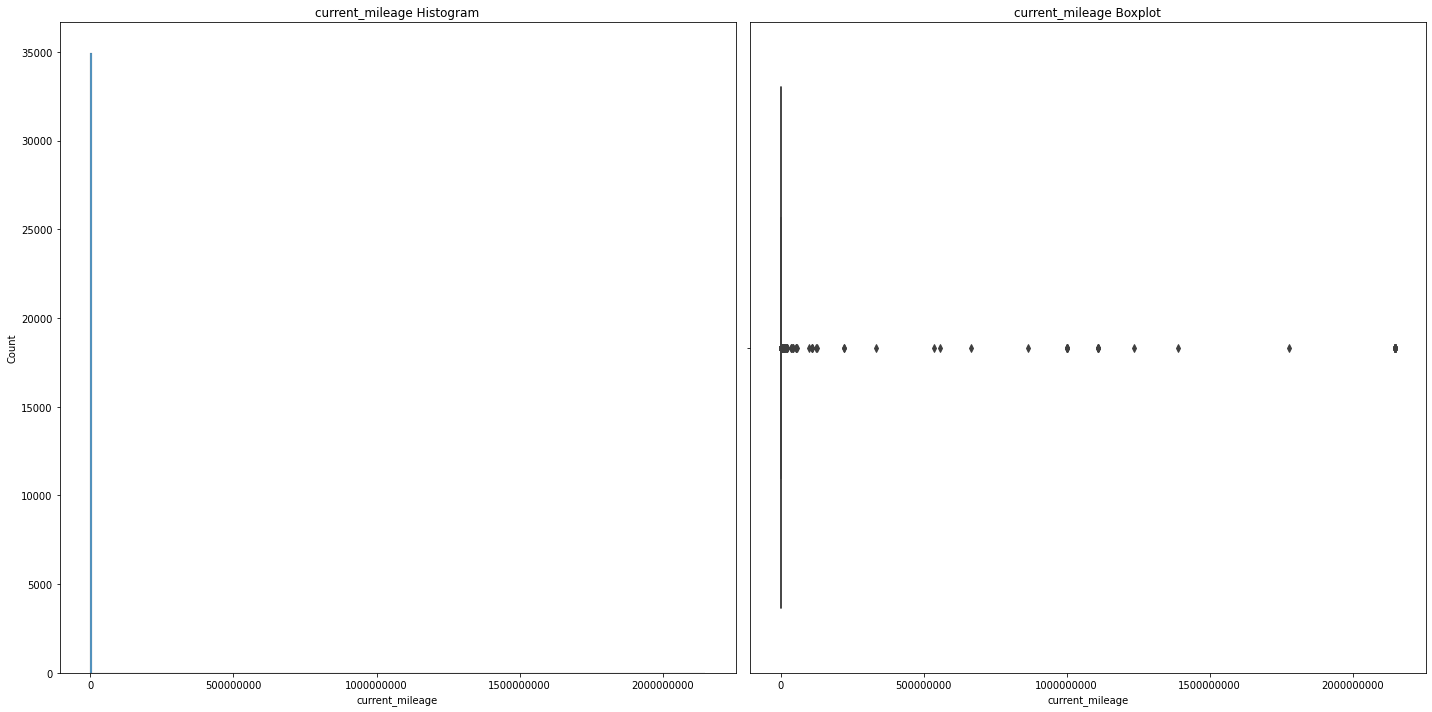

In [72]:
get_graph(train_data, 'current_mileage')

In [73]:
info, outliers_milleage, cleaned_milleage = outliers_iqr(train_data, 'current_mileage', left=1.5, right=1.3)
print(info)

Количество выбросов: 1453 (в процентах: 4.15%).


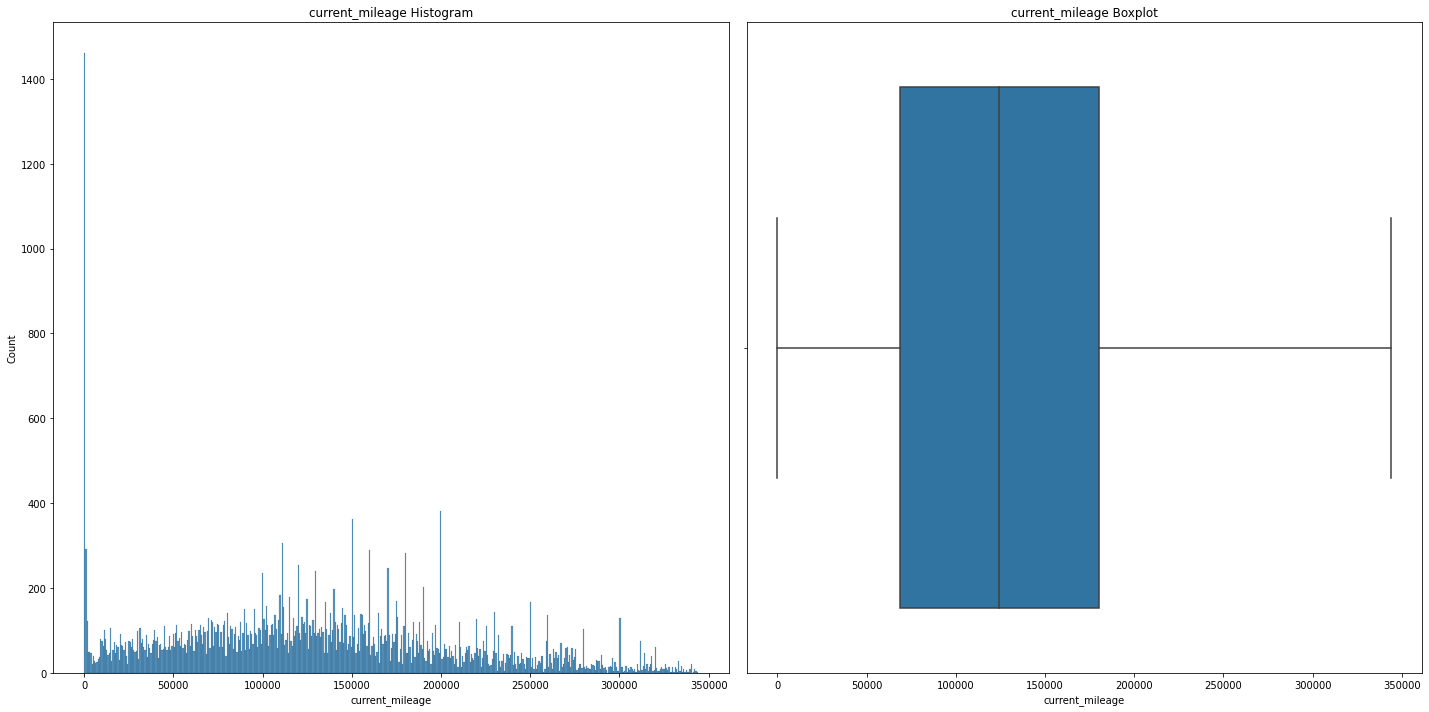

In [74]:
get_graph(cleaned_milleage, 'current_mileage')

In [75]:
outliers_index_milleage_train = list(outliers_milleage.index)

In [77]:
train_data['outliers'] = train_data.apply(mark_by_index, axis=1, args=(outliers_index_milleage_train,))

In [78]:
info, outliers_milleage, cleaned_milleage = outliers_iqr(test_data, 'current_mileage', left=1.5, right=1.3)
print(info)

Количество выбросов: 460 (в процентах: 4.30%).


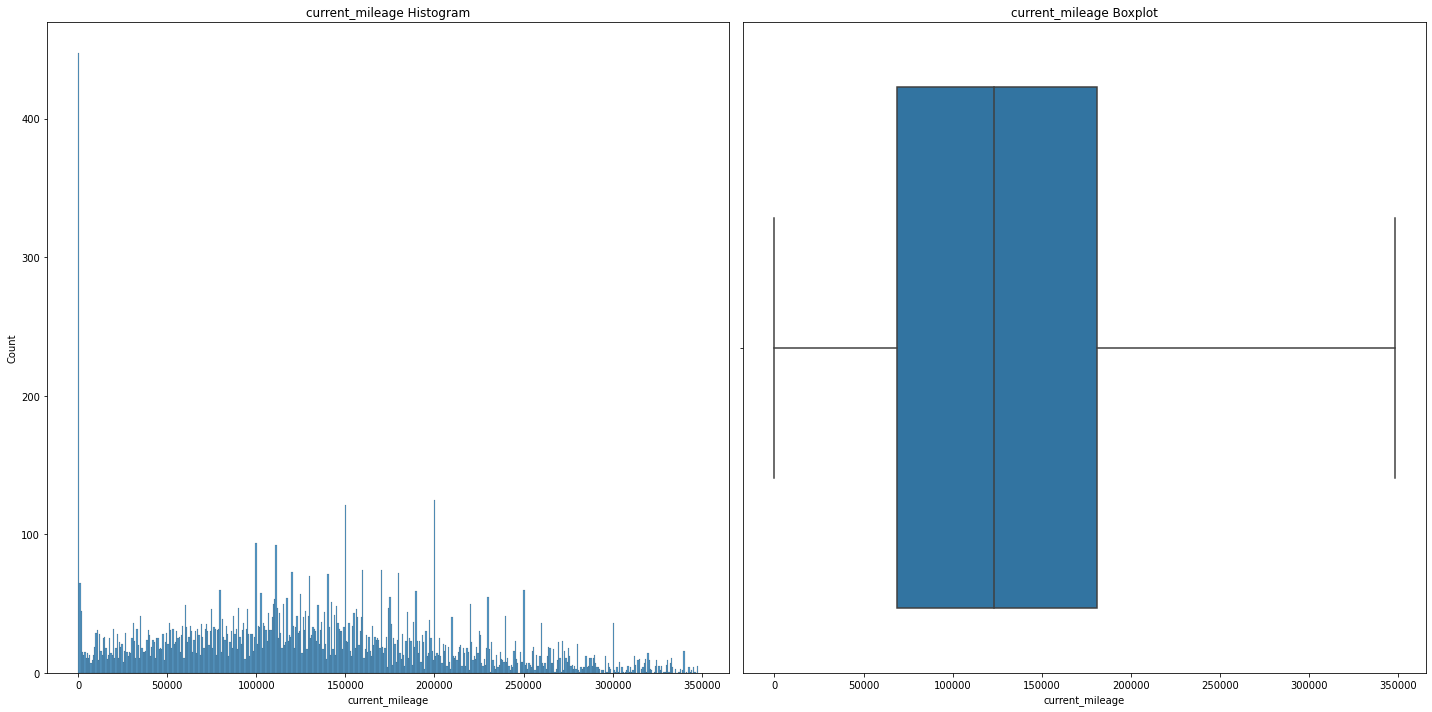

In [79]:
get_graph(cleaned_milleage, 'current_mileage')

In [80]:
outliers_index_milleage_test = list(outliers_milleage.index)

In [81]:
test_data['outliers'] = test_data.apply(mark_by_index, axis=1, args=(outliers_index_milleage_test,))

In [82]:
train_data = train_data[train_data['current_mileage'] < 500_000]

In [83]:
re = r'[1]{5,}|[2]{5,}|[3]{5,}|[4]{5,}|[5]{5,}|[6]{5,}|[7]{5,}|[8]{5,}|[9]{5,}'

In [84]:
train_strange_mileage = train_data[train_data['current_mileage'].astype('str').str.match(re)]
train_strange_mileage

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers
402,402,VOLKSWAGEN,Passat,Sedan,222222,Manual,4/5,Left wheel,Black,Black,0,1,For Sale,1700.0,22,False
404,404,FORD,Transit,Microbus,111111,Manual,2/3,Left wheel,Blue,Black,0,0,For Sale,3700.0,22,False
538,538,HONDA,FIT,Sedan,111111,Automatic,4/5,Left wheel,Grey,Black,0,0,For Sale,2800.0,13,False
609,609,DODGE,Caravan,Minivan,11111,Automatic,4/5,Left wheel,Blue,Black,0,0,For Sale,1300.0,23,False
610,610,SUBARU,Legacy,Sedan,222222,Tiptronic,4/5,Right-hand drive,Black,Black,0,0,For Sale,1900.0,18,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34041,34041,OPEL,Vectra,Sedan,222222,Manual,4/5,Left wheel,Carnelian red,Black,0,0,For Sale,1500.0,27,False
34447,34447,VOLKSWAGEN,Golf,Hatchback,111111,Manual,4/5,Left wheel,Silver,Black,0,0,For Sale,1900.0,21,False
34690,34690,MERCEDES-BENZ,C 300,Sedan,111111,Tiptronic,4/5,Left wheel,Black,Black,0,1,For Sale,6500.0,11,False
34763,34763,FORD,Transit,Goods wagon,11111,Manual,4/5,Left wheel,White,Beige,0,0,For Sale,3348.0,24,False


In [85]:
outliers_milleage_train = list(train_strange_mileage.index)
train_data['outliers'] = train_data.apply(mark_by_index, axis=1, args=(outliers_milleage_train,),)

In [86]:
test_strange_mileage = test_data[test_data['current_mileage'].astype('str').str.match(re)]
test_strange_mileage

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,vehicle_age,outliers
34,35034,BMW,530 E60,Sedan,111111,Tiptronic,4/5,Left wheel,Silver,Black,0,1,For Sale,17,False
127,35127,BMW,535,Sedan,111111,Tiptronic,4/5,Left wheel,Black,Black,0,1,For Sale,13,False
352,35352,FORD,Escape,Jeep,111111,Automatic,4/5,Left wheel,Silver,Grey,0,0,For Sale,13,False
525,35525,BMW,525,Sedan,7777787,Manual,4/5,Left wheel,Silver,Grey,0,1,For Sale,18,False
703,35703,LEXUS,RX 350,Sedan,99999,Automatic,4/5,Left wheel,Black,Black,0,1,For Rent,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10023,45023,HONDA,FIT,Sedan,111111,Automatic,4/5,Right-hand drive,Grey,Black,0,0,For Sale,17,False
10264,45264,VAZ,2107,Sedan,77777,Manual,4/5,Left wheel,White,Beige,0,0,For Sale,24,False
10537,45537,JEEP,Grand Cherokee,Jeep,111111,Tiptronic,4/5,Left wheel,Brown,White,0,0,For Sale,16,False
10548,45548,BMW,328,Sedan,111111,Manual,4/5,Left wheel,Green,Black,0,1,For Sale,21,False


In [87]:
outliers_milleage_test = list(test_strange_mileage.index)
test_data['outliers'] = test_data.apply(mark_by_index, axis=1, args=(outliers_milleage_test,),)

### final_price

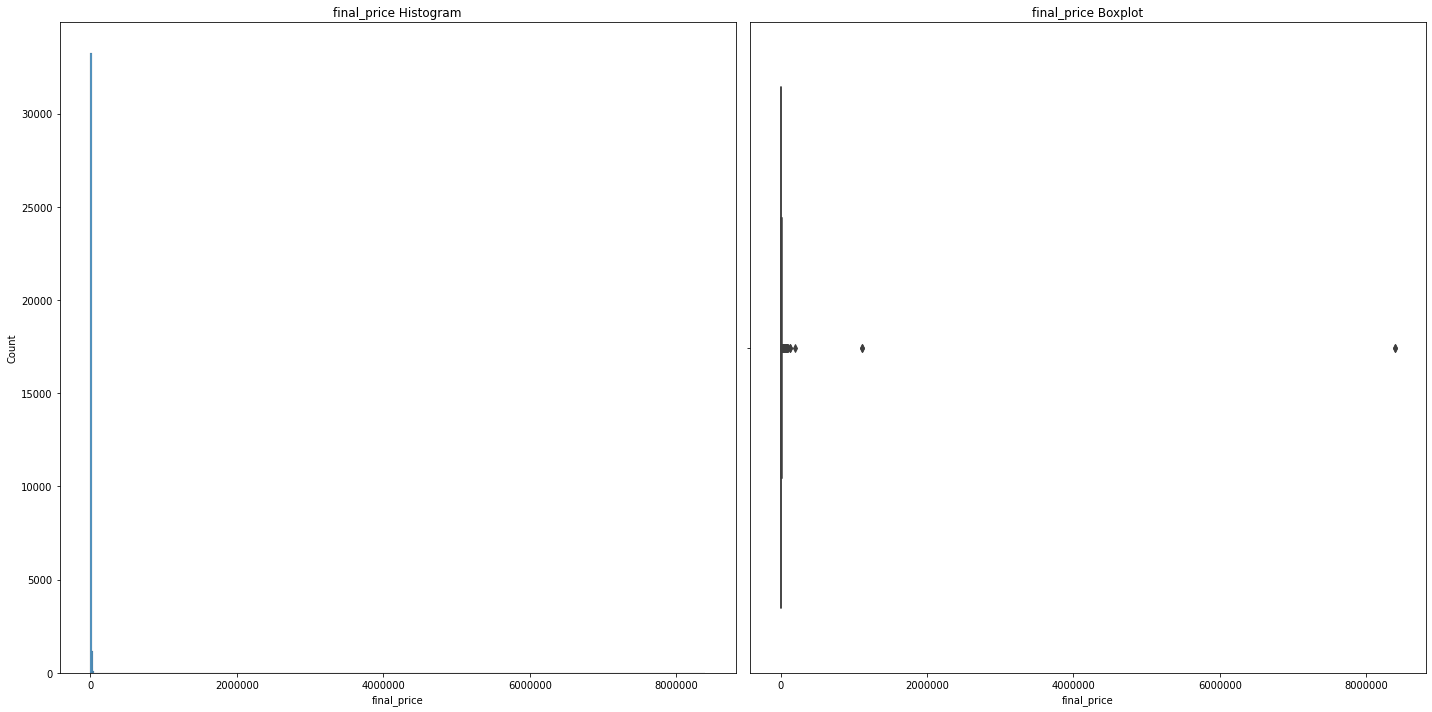

In [88]:
get_graph(train_data, 'final_price')

In [89]:
train_data['final_price'].describe()

count    3.458000e+04
mean     5.856238e+03
std      6.458899e+04
min      0.000000e+00
25%      1.350000e+03
50%      3.900000e+03
75%      7.000000e+03
max      8.388607e+06
Name: final_price, dtype: float64

In [92]:
train_data = train_data[(train_data['final_price'] > 10) & (train_data['final_price'] <= 200_000)]

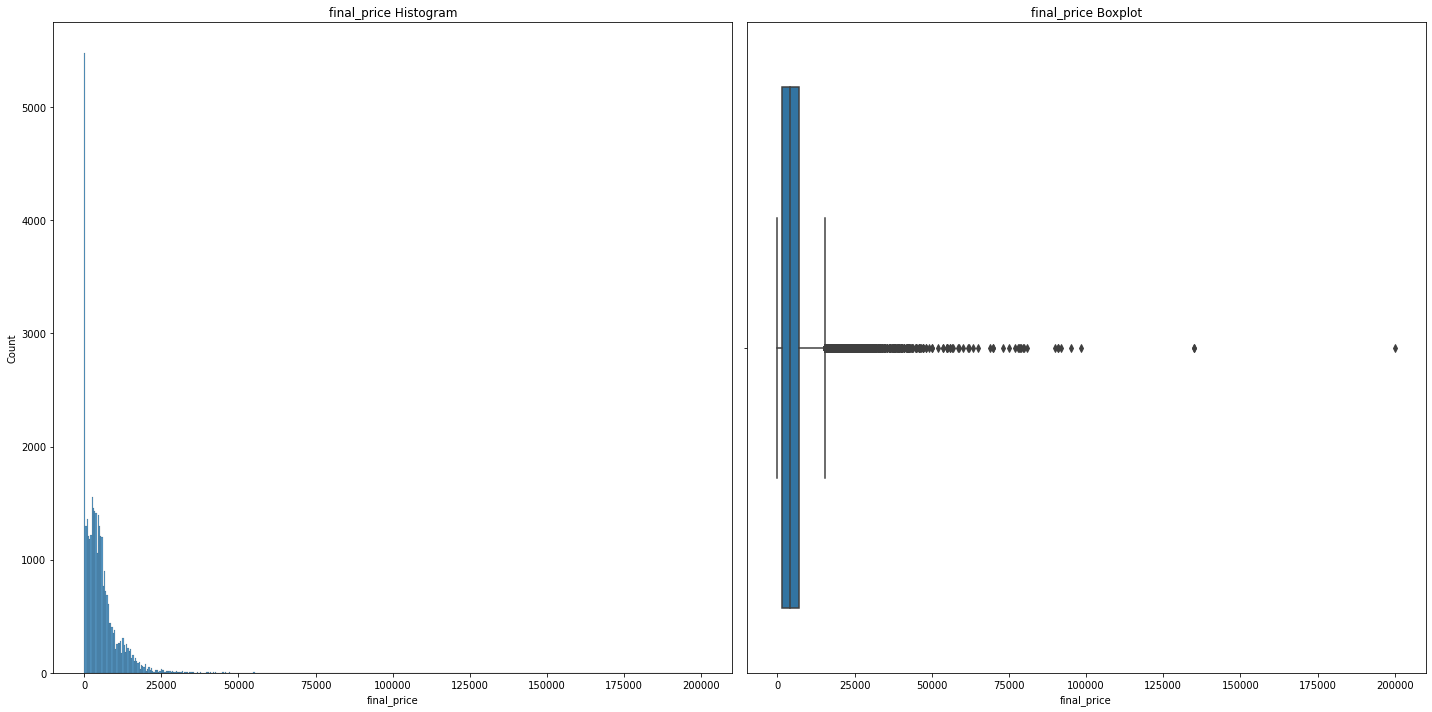

In [93]:
get_graph(train_data, 'final_price')

## 3. Убираем дубликаты

In [94]:
cols = list(test_data.columns)[1:]
cols.remove('outliers')
cols.remove('deal_type')
cols

['vehicle_manufacturer',
 'vehicle_model',
 'vehicle_category',
 'current_mileage',
 'vehicle_gearbox_type',
 'doors_cnt',
 'wheels',
 'vehicle_color',
 'vehicle_interior_color',
 'car_vin',
 'car_leather_interior',
 'vehicle_age']

In [95]:
train_data['duplicate'] = train_data.duplicated(subset=cols)
test_data['duplicate'] = test_data.duplicated(subset=cols)

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [96]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (27498, 17), te_data = (6875, 17)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers,duplicate
26191,26191,TOYOTA,Prius,Hatchback,137000,Variator,4/5,Left wheel,White,Golden,0,0,For Sale,6250.0,10,False,False
29216,29216,HONDA,Civic,Sedan,77120,Automatic,4/5,Left wheel,Black,Black,1,1,For Sale,100.0,8,False,True
17163,17163,TOYOTA,Celica,Coupe,204000,Manual,2/3,Right-hand drive,Silver,Black,0,1,For Sale,1800.0,21,False,False
7433,7433,DODGE,Charger RT,Sedan,225000,Automatic,4/5,Left wheel,Black,Grey,0,1,For Sale,5800.0,15,False,False
33089,33089,TOYOTA,Camry,Sedan,169600,Tiptronic,4/5,Left wheel,Black,Black,0,1,For Sale,8500.0,8,False,False


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [97]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [98]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID', 'deal_type'] 
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [99]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

### Для обучения попробуем сразу весь train дать

In [100]:
%%time
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[10:04:19] Stdout logging level is INFO.
[10:04:19] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[10:04:19] Task: reg

[10:04:19] Start automl preset with listed constraints:
[10:04:19] - time: 1000.00 seconds
[10:04:19] - CPU: 4 cores
[10:04:19] - memory: 16 GB

[10:04:19] Train data shape: (27498, 17)

[10:04:24] Layer 1 train process start. Time left 994.76 secs
[10:04:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:04:45] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2661.452880606754
[10:04:45] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:04:45] Time left 974.00 secs

[10:04:49] Selector_LightGBM fitting and predicting completed
[10:04:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:05:18] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1912.2618510066038
[10:05:18] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[10:05:18] Start hyperparameters optimization for Lvl_0

In [101]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (4 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [102]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[5537.0483 ],
       [ 643.0491 ],
       [4909.1016 ],
       ...,
       [ 254.51633],
       [5972.318  ],
       [1096.4443 ]], dtype=float32)
Shape = (6875, 1)
CPU times: user 19 s, sys: 905 µs, total: 19 s
Wall time: 4.93 s


In [103]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

In [ ]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [104]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2839.787 ],
       [ 5568.1724],
       [ 6863.6636],
       ...,
       [18546.262 ],
       [ 4135.385 ],
       [ 6617.355 ]], dtype=float32)
Shape = (10697, 1)


In [109]:
submission[TARGET_NAME] = test_pred.data[:, 0]

In [110]:
submission.at[rent_cars_index_test, 'final_price'] = 16

In [111]:
submission.at[vehicle_year_index_test, 'final_price'] = 0

In [112]:
submission.to_csv('final_v1', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [ ]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)